<a href="https://colab.research.google.com/github/sureshmecad/Google-Colab/blob/master/Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 6: Python Business Analytics


See the Repository for Future Work: https://github.com/firmai/python-business-analytics or


Sign up to the mailing list:
https://mailchi.mp/ec4942d52cc5/firmai

# Demand Forecasting

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.stats import describe
import seaborn as sns
from pylab import rcParams

pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

# disable warnings in Anaconda
warnings.simplefilter('ignore')

# plots inisde jupyter notebook
%matplotlib inline

sns.set(style='darkgrid', palette='muted')
color_scheme = {
    'red': '#F1637A',
    'green': '#6ABB3E',
    'blue': '#3D8DEA',
    'black': '#000000'
}

# use svg for all plots within inline backend
%config InlineBackend.figure_format = 'svg'

# increase default plot size
rcParams['figure.figsize'] = 8, 6

In [ ]:
df_train = pd.read_csv('https://raw.githubusercontent.com/firmai/python-business-analytics/master/data/customer/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/firmai/python-business-analytics/master/data/customer/test.csv')

Before we do anything, we want to have both sets in a format with 500 sales columns and 1 row for each day.

In [ ]:
df_train.index = pd.to_datetime(df_train['date'])
df_train.drop('date', axis=1, inplace=True)
df_test.index = pd.to_datetime(df_test['date'])
df_test.drop('date', axis=1, inplace=True)

In [ ]:
df_train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [ ]:
from itertools import product, starmap


def storeitems():
    return product(range(1,51), range(1,11))


def storeitems_column_names():
    return list(starmap(lambda i,s: f'item_{i}_store_{s}_sales', storeitems()))


def sales_by_storeitem(df):
    ret = pd.DataFrame(index=df.index.unique())
    for i, s in storeitems():
        ret[f'item_{i}_store_{s}_sales'] = df[(df['item'] == i) & (df['store'] == s)]['sales'].values
    return ret

In [ ]:
df_train = sales_by_storeitem(df_train)
# for test set, we just fill y values with zeros (they won't be used anyway)
df_test['sales'] = np.zeros(df_test.shape[0])
df_test = sales_by_storeitem(df_test)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: int64(500)
memory usage: 7.0 MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2018-01-01 to 2018-03-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: float64(500)
memory usage: 352.3 KB


We combine data to prepare it for the model, and later split back into train and test set, not to repeat same transformations twice.

In [ ]:
# make sure all column names are the same and in the same order
col_names = list(zip(df_test.columns, df_train.columns))
for cn in col_names:
    assert cn[0] == cn[1]

In [ ]:
df_test['is_test'] = np.repeat(True, df_test.shape[0])
df_train['is_test'] = np.repeat(False, df_train.shape[0])
df_total = pd.concat([df_train, df_test])
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1916 entries, 2013-01-01 to 2018-03-31
Columns: 501 entries, item_1_store_1_sales to is_test
dtypes: bool(1), float64(500)
memory usage: 7.3 MB


In [ ]:
weekday_df = pd.get_dummies(df_total.index.weekday, prefix='weekday')
weekday_df.index = df_total.index

In [ ]:
month_df = pd.get_dummies(df_total.index.month, prefix='month')
month_df.index =  df_total.index

In [ ]:
df_total = pd.concat([weekday_df, month_df, df_total], axis=1)

In [ ]:
assert df_total.isnull().any().any() == False

We also want to append sales from previous day to each row, which we will then use as input data.

In [ ]:
def shift_series(series, days):
    return series.transform(lambda x: x.shift(days))


def shift_series_in_df(df, series_names=[], days_delta=90):
    ret = pd.DataFrame(index=df.index.copy())
    str_sgn = 'future' if np.sign(days_delta) < 0 else 'past'
    for sn in series_names:
        ret[f'{sn}_{str_sgn}_{np.abs(days_delta)}'] = shift_series(df[sn], days_delta)
    return ret

    
def stack_shifted_sales(df, days_deltas=[1, 90, 360]):
    names = storeitems_column_names()
    dfs = [df.copy()]
    for delta in days_deltas:
        shifted = shift_series_in_df(df, series_names=names, days_delta=delta)
        dfs.append(shifted)
    return pd.concat(dfs, axis=1, copy=False)

In [ ]:
df_total = stack_shifted_sales(df_total, days_deltas=[1])
df_total.dropna(inplace=True)

In [ ]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1915 entries, 2013-01-02 to 2018-03-31
Columns: 1020 entries, weekday_0 to item_50_store_10_sales_past_1
dtypes: bool(1), float64(1000), uint8(19)
memory usage: 14.7 MB


We need to make sure that stacked and not-stacked sales columns appar in the same order. We do this by sorting the names (as strings), which works fine because we only need 1 past day for the network (see regression models and their rolling mechanism if you are interested in rolling more than 1 past days of sales as input).

In [ ]:
sales_cols = [col for col in df_total.columns if '_sales' in col and '_sales_' not in col]
stacked_sales_cols = [col for col in df_total.columns if '_sales_' in col]
other_cols = [col for col in df_total.columns if col not in set(sales_cols) and col not in set(stacked_sales_cols)]

sales_cols = sorted(sales_cols)
stacked_sales_cols = sorted(stacked_sales_cols)

new_cols = other_cols + stacked_sales_cols + sales_cols

In [ ]:
df_total = df_total.reindex(columns=new_cols)

In [ ]:
assert df_total.isnull().any().any() == False

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
cols_to_scale = [col for col in df_total.columns if 'weekday' not in col and 'month' not in col]
scaled_cols = scaler.fit_transform(df_total[cols_to_scale])
df_total[cols_to_scale] = scaled_cols

In [ ]:
df_train = df_total[df_total['is_test'] == False].drop('is_test', axis=1)
df_test = df_total[df_total['is_test'] == True].drop('is_test', axis=1)

In [ ]:
X_cols_stacked = [col for col in df_train.columns if '_past_' in col]
X_cols_caldata = [col for col in df_train.columns if 'weekday_' in col or 'month_' in col or 'year' in col]
X_cols = X_cols_stacked + X_cols_caldata

X = df_train[X_cols]

In [ ]:
X_colset = set(X_cols)
y_cols = [col for col in df_train.columns if col not in X_colset]

y = df_train[y_cols]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 519 entries, item_10_store_10_sales_past_1 to month_12
dtypes: float64(500), uint8(19)
memory usage: 7.0 MB


In [ ]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 500 entries, item_10_store_10_sales to item_9_store_9_sales
dtypes: float64(500)
memory usage: 7.0 MB


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
X_valid, y_valid = X_valid.head(90), y_valid.head(90)

For Keras, we need to make further transformations on input values:

In [ ]:
X_train_vals = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

In [ ]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Conv1D, Input, Dropout, AvgPool1D, Reshape, Concatenate

Using TensorFlow backend.


Simple LSTM model:

In [ ]:
basic_model = Sequential()
basic_model.add(LSTM(500, input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])))
basic_model.add(Dense(500))
basic_model.compile(loss='mean_absolute_error', optimizer='adam')

W0723 02:07:55.367423 140586883549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 02:07:55.414469 140586883549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 02:07:55.426332 140586883549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 02:07:56.073612 140586883549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



More complex model combining LSTM with convolutional layers:

In [ ]:
inputs = Input(shape=(X_train_vals.shape[1], X_train_vals.shape[2]))
# top pipeline
top_lstm = LSTM(500)(inputs)
top_dense = Dense(500, activation='relu')(top_lstm)
top_dropout = Dropout(500)(top_dense)
# bottom pipeline
bottom_dense = Dense(500)(inputs)
bottom_conv1 = Conv1D(
    500, 
    kernel_size=1,
    input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])
)(bottom_dense)
bottom_conv2 = Conv1D(
    1000,
    kernel_size=50,
    padding='same',
    activation='relu'
)(bottom_conv1)
bottom_conv3 = Conv1D(
    500,
    kernel_size=10,
    padding='same',
    activation='relu'
)(bottom_conv2)
bottom_pooling = AvgPool1D(
    pool_size=60, 
    padding='same'
)(bottom_conv3)
bottom_reshape = Reshape(
    target_shape=[500]
)(bottom_conv3)
# concat output from both pipelines
final_concat = Concatenate()([top_dropout, bottom_reshape])
final_dense = Dense(500)(final_concat)
# compile and return
complex_model = Model(inputs=inputs, outputs=final_dense)
complex_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

W0723 02:07:56.898257 140586883549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



Now we can fit the models:

In [ ]:
basic_history = basic_model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=60, 
    batch_size=30,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False
)

W0723 02:07:57.151805 140586883549056 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0723 02:07:57.623511 140586883549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0723 02:07:57.706365 140586883549056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1460 samples, validate on 90 samples
Epoch 1/60
 - 5s - loss: 0.1452 - val_loss: 0.0935
Epoch 2/60
 - 0s - loss: 0.0942 - val_loss: 0.0736
Epoch 3/60
 - 0s - loss: 0.0851 - val_loss: 0.0689
Epoch 4/60
 - 0s - loss: 0.0742 - val_loss: 0.0626
Epoch 5/60
 - 0s - loss: 0.0717 - val_loss: 0.0594
Epoch 6/60
 - 0s - loss: 0.0702 - val_loss: 0.0609
Epoch 7/60
 - 0s - loss: 0.0700 - val_loss: 0.0688
Epoch 8/60
 - 0s - loss: 0.0905 - val_loss: 0.0858
Epoch 9/60
 - 0s - loss: 0.0921 - val_loss: 0.0754
Epoch 10/60
 - 0s - loss: 0.0756 - val_loss: 0.0729
Epoch 11/60
 - 0s - loss: 0.0787 - val_loss: 0.0645
Epoch 12/60
 - 0s - loss: 0.0683 - val_loss: 0.0642
Epoch 13/60
 - 0s - loss: 0.0710 - val_loss: 0.0580
Epoch 14/60
 - 0s - loss: 0.0604 - val_loss: 0.0574
Epoch 15/60
 - 0s - loss: 0.0653 - val_loss: 0.0569
Epoch 16/60
 - 0s - loss: 0.0643 - val_loss: 0.0624
Epoch 17/60
 - 0s - loss: 0.0701 - val_loss: 0.0646
Epoch 18/60
 - 0s - loss: 0.0651 - val_loss: 0.0562
Epoch 19/60
 - 0s - loss: 0

In [ ]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

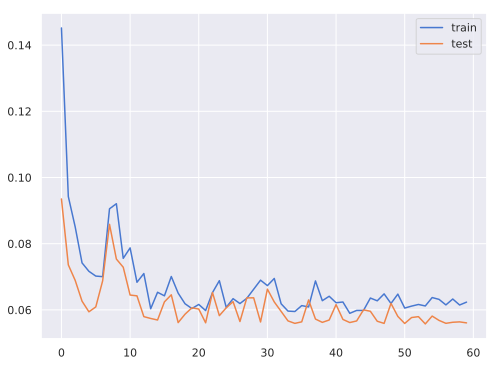

In [ ]:
plot_history(basic_history)

In [ ]:
complex_history = complex_model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=20, 
    batch_size=70,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False
)

Train on 1460 samples, validate on 90 samples
Epoch 1/20
 - 9s - loss: 0.0494 - mean_absolute_percentage_error: 187.0228 - val_loss: 0.0143 - val_mean_absolute_percentage_error: 26.1812
Epoch 2/20
 - 2s - loss: 0.0128 - mean_absolute_percentage_error: 384.1690 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 20.6958
Epoch 3/20
 - 2s - loss: 0.0099 - mean_absolute_percentage_error: 367.2869 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 19.2779
Epoch 4/20
 - 2s - loss: 0.0091 - mean_absolute_percentage_error: 336.3649 - val_loss: 0.0088 - val_mean_absolute_percentage_error: 21.0721
Epoch 5/20
 - 2s - loss: 0.0092 - mean_absolute_percentage_error: 352.0442 - val_loss: 0.0110 - val_mean_absolute_percentage_error: 24.5483
Epoch 6/20
 - 2s - loss: 0.0091 - mean_absolute_percentage_error: 321.5696 - val_loss: 0.0063 - val_mean_absolute_percentage_error: 17.0722
Epoch 7/20
 - 2s - loss: 0.0076 - mean_absolute_percentage_error: 291.6908 - val_loss: 0.0059 - val_mean_absolute_

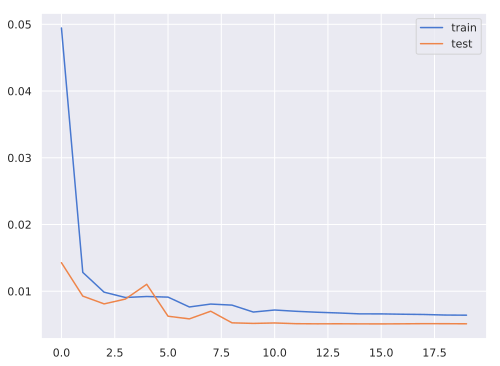

In [ ]:
plot_history(complex_history)

## Evaluating model predictions

In [ ]:
def model_eval(model, X_test, y_test):
    """
    Evaluate (step-by-step) model predictions from X_test and return predictions and real values in comparable format.
    """
    # prepare data
    sales_x_cols = [col for col in X_test.columns if 'sales' in col]
    sales_x_idxs = [X_test.columns.get_loc(col) for col in sales_x_cols]
    sales_y_cols = [col for col in y_test.columns if 'sales' in col]
    sales_y_idxs = [y_test.columns.get_loc(col) for col in sales_y_cols]
    n_samples = y_test.shape[0]
    y_pred = np.zeros(y_test.shape)
    # iterate
    x_next = X_test.iloc[0].values
    for i in range(0, n_samples):
        x_arr = np.array([x_next])
        x_arr = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])
        y_pred[i] = model.predict(x_arr)[0] # input for prediction must be 2d, output is immediately extracted from 2d to 1d
        try:
            x_next = X_test.iloc[i+1].values
            x_next[sales_x_idxs] = y_pred[i][sales_y_idxs]
        except IndexError:
            pass  # this happens on last iteration, and x_next does not matter anymore
    return y_pred, y_test.values


def unscale(y_arr, scaler, template_df, toint=False):
    """
    Unscale array y_arr of model predictions, based on a scaler fitted 
    to template_df.
    """
    tmp = template_df.copy()
    tmp[y_cols] = pd.DataFrame(y_arr, index=tmp.index)
    tmp[cols_to_scale] = scaler.inverse_transform(tmp[cols_to_scale])
    if toint:
        return tmp[y_cols].astype(int)
    return tmp[y_cols]


def vector_smape(y_pred, y_real):
    nom = np.abs(y_pred-y_real)
    denom = (np.abs(y_pred) + np.abs(y_real)) / 2
    results = nom / denom
    return 100*np.mean(results)  # in percent, same as at kaggle

In [ ]:
y_pred_basic, y_real = model_eval(basic_model, X_valid, y_valid)

In [ ]:
y_pred_complex = model_eval(complex_model, X_valid, y_valid)[0]

In [ ]:
# this is just for unscaling
template_df = pd.concat([X_valid, y_valid], axis=1)
template_df['is_test'] = np.repeat(True, template_df.shape[0])

In [ ]:
basic_pred = unscale(y_pred_basic, scaler, template_df, toint=True)
complex_pred = unscale(y_pred_complex, scaler, template_df, toint=True)
real = unscale(y_real, scaler, template_df, toint=True)

In [ ]:
basic_smapes = [vector_smape(basic_pred[col], real[col]) for col in basic_pred.columns]
complex_smapes = [vector_smape(complex_pred[col], real[col]) for col in complex_pred.columns]

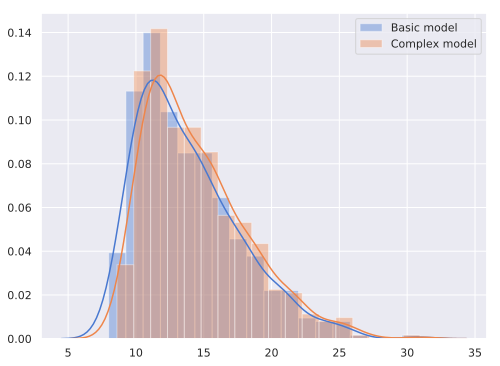

In [ ]:
sns.distplot(basic_smapes, label='Basic model')
sns.distplot(complex_smapes, label='Complex model')
plt.legend(loc='upper right')
plt.savefig('smape_basic_vs_complex.svg')
plt.show()

Depending on training parameters, basic model can sometimes achieve results comparable to the complex one, however after uploading to Kaggle complex model achieved better (and more consistent) results.

In [ ]:
describe(basic_smapes)

DescribeResult(nobs=500, minmax=(7.989599833522128, 30.891542066572953), mean=13.874763147166014, variance=14.4148552573537, skewness=0.9831134066812554, kurtosis=0.823984335714159)

In [ ]:
describe(complex_smapes)

DescribeResult(nobs=500, minmax=(8.602601904926251, 30.950680183748254), mean=14.454597793910583, variance=14.22178579642389, skewness=0.9814451910333111, kurtosis=0.783496207172536)

### Visualizing model prediction
We will plot predictions of 2 models for a sample store and item.

In [ ]:
store, item = 1,1
plot_lengths = [7, 30, 90]
rolling_mean_windows = [1, 1, 2]  # to make plots more readable

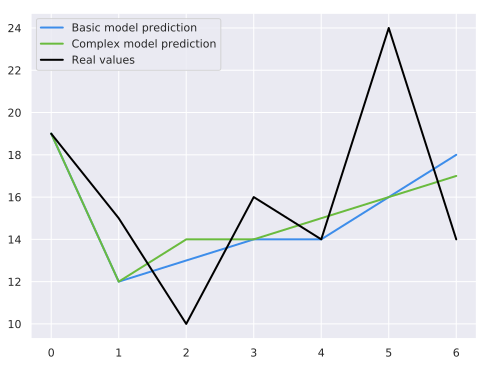

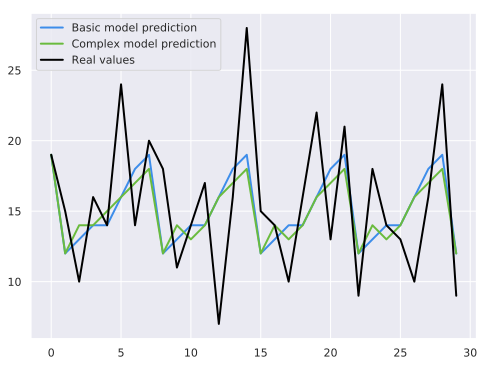

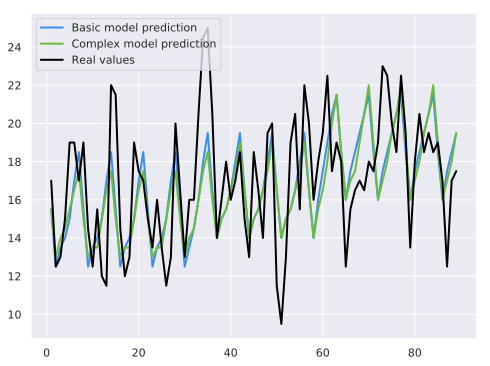

In [ ]:
storeitem_col = f'item_{item}_store_{store}_sales'

for pl, mw in zip(plot_lengths, rolling_mean_windows):
    plt.plot(basic_pred[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['blue'],
             lw=2,
             label='Basic model prediction')
    plt.plot(complex_pred[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['green'],
             lw=2, 
             label='Complex model prediction')
    plt.plot(real[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['black'],
             lw=2, 
             label='Real values')
    plt.legend(loc='upper left')
    plt.savefig(f'plot_prediction_{pl}_{mw}.svg')
    plt.show()

In [ ]:
filename = 'neuralNetwork.sav'
filename1 = 'basicmodel.sav'

In [ ]:
import pickle

In [ ]:
pickle.dump(complex_model, open(filename, 'wb'))

In [ ]:
pickle.dump(basic_model, open(filename1, 'wb'))

In [ ]:
pd.DataFrame(complex_pred).to_csv("file.csv")

In [ ]:
pd.DataFrame(real).to_csv("file1.csv")

Credit: [Vinay Ak](https://github.com/Vinayak02)

Repository: [Customer Centric](https://github.com/Vinayak02/CustomerCentricRetail)
